In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
from selection import models, data

In [2]:
# Load train set
train = dsets.MNIST('./', train=True, download=True)
imgs = train.data.reshape(-1, 784) / 255.0
labels = train.targets

# Shuffle and split into train and val
inds = torch.randperm(len(train))
imgs = imgs[inds]
labels = labels[inds]
val_x, val_y = imgs[:6000], labels[:6000]
train_x, train_y = imgs[6000:], labels[6000:]

# Load test set
test = dsets.MNIST('./', train=False, download=True)
test_x = test.data.reshape(-1, 784) / 255.0
test_y = test.targets

# Create TabularDatasets (for specifying feature indices)
train_set = data.TabularDataset(train_x, train_y)
val_set = data.TabularDataset(val_x, val_y)
test_set = data.TabularDataset(test_x, test_y)
input_size = train_set.input_size
output_size = train_set.output_size

# Concrete mask

In [3]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_mask',
    k=20,
    input_size=input_size,
    output_size=output_size,
    hidden=[512, 512],
    activation='elu').cuda()

# Train model
model.learn(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=300,
    start_temperature=10.0,
    end_temperature=0.01,
    loss_fn=nn.CrossEntropyLoss(),
    check_every=30)

--------Epoch = 30--------
Train loss = 0.1628
Val loss = 0.1940
Max = 0.01, Mean = 0.01, Min = 0.01
--------Epoch = 60--------
Train loss = 0.1127
Val loss = 0.1629
Max = 0.04, Mean = 0.03, Min = 0.02
--------Epoch = 90--------
Train loss = 0.1780
Val loss = 0.2209
Max = 0.14, Mean = 0.10, Min = 0.08
--------Epoch = 120--------
Train loss = 0.2774
Val loss = 0.3060
Max = 0.38, Mean = 0.25, Min = 0.19
--------Epoch = 150--------
Train loss = 0.3300
Val loss = 0.3789
Max = 0.87, Mean = 0.50, Min = 0.31
--------Epoch = 180--------
Train loss = 0.2480
Val loss = 0.3169
Max = 1.00, Mean = 0.86, Min = 0.54
--------Epoch = 210--------
Train loss = 0.1065
Val loss = 0.3424
Max = 1.00, Mean = 0.99, Min = 0.95
--------Epoch = 240--------
Train loss = 0.0418
Val loss = 0.4971
Max = 1.00, Mean = 1.00, Min = 0.99
Stopping early


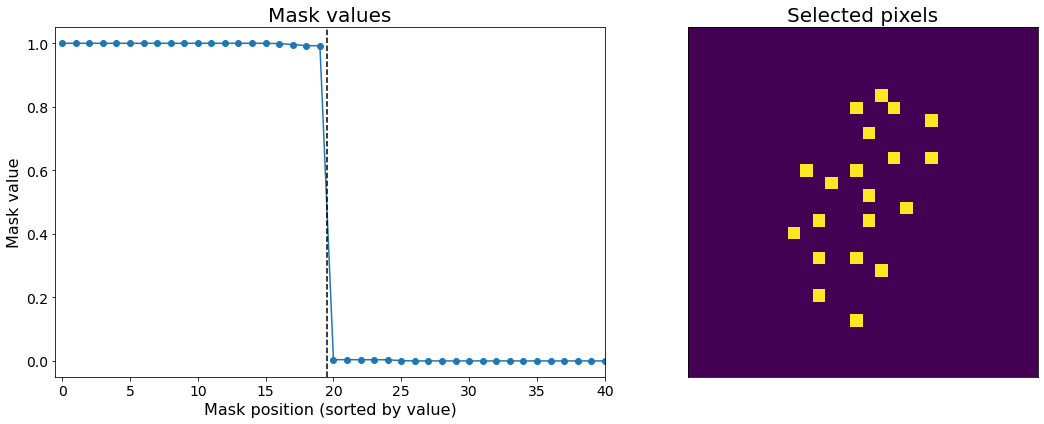

In [4]:
# Verify convergence
m = model.input_layer.sample(n_samples=256)
values = torch.mean(m, dim=0)
sorted_values = torch.sort(values, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
ax.plot(np.arange(input_size), sorted_values.cpu().data, marker='o')
ax.axvline(model.input_layer.k - 0.5, color='black', linestyle='--')
ax.set_xlim(-0.5, 2 * model.input_layer.k)
ax.set_title('Mask values', fontsize=20)
ax.set_xlabel('Mask position (sorted by value)', fontsize=16)
ax.set_ylabel('Mask value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(values.cpu().data, (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [5]:
# Extract select inds
inds = model.get_inds()

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[512, 512],
    activation='elu').cuda()

model.learn(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(
    model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.912


# Concrete selector

In [6]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_selector',
    k=20,
    input_size=input_size,
    output_size=output_size,
    hidden=[512, 512],
    activation='elu').cuda()

# Train model
model.learn(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=300,
    start_temperature=10.0,
    end_temperature=0.01,
    loss_fn=nn.CrossEntropyLoss(),
    check_every=30)

--------Epoch = 30--------
Train loss = 0.4622
Val loss = 0.4773
Max = 0.00, Mean = 0.00, Min = 0.00
--------Epoch = 60--------
Train loss = 0.3636
Val loss = 0.3665
Max = 0.01, Mean = 0.01, Min = 0.00
--------Epoch = 90--------
Train loss = 0.4361
Val loss = 0.4387
Max = 0.12, Mean = 0.06, Min = 0.01
--------Epoch = 120--------
Train loss = 0.3232
Val loss = 0.3548
Max = 0.82, Mean = 0.52, Min = 0.20
--------Epoch = 150--------
Train loss = 0.2223
Val loss = 0.3321
Max = 0.99, Mean = 0.85, Min = 0.35
--------Epoch = 180--------
Train loss = 0.1574
Val loss = 0.3781
Max = 1.00, Mean = 0.94, Min = 0.46
--------Epoch = 210--------
Train loss = 0.0999
Val loss = 0.4632
Max = 1.00, Mean = 0.98, Min = 0.74
--------Epoch = 240--------
Train loss = 0.0689
Val loss = 0.5715
Max = 1.00, Mean = 0.99, Min = 0.84
--------Epoch = 270--------
Train loss = 0.0615
Val loss = 0.7051
Max = 1.00, Mean = 0.99, Min = 0.90
--------Epoch = 300--------
Train loss = 0.0454
Val loss = 0.8005
Max = 1.00, Mean = 

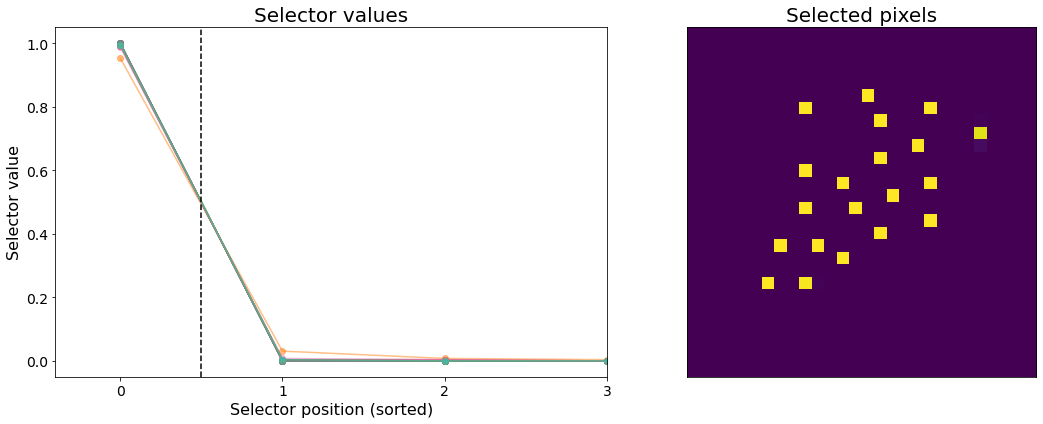

In [7]:
# Verify convergence
M = model.input_layer.sample(n_samples=256)
values = torch.mean(M, dim=0)
sorted_values = torch.sort(values, dim=1, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
for i in range(model.input_layer.k):
    ax.plot(np.arange(input_size), sorted_values[i].cpu().data,
            marker='o', alpha=0.5)
ax.set_xlim(-0.4, 3)
ax.set_xticks(np.arange(4))
ax.axvline(0.5, color='black', linestyle='--')
ax.set_title('Selector values', fontsize=20)
ax.set_xlabel('Selector position (sorted)', fontsize=16)
ax.set_ylabel('Selector value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(torch.sum(values, dim=0).cpu().data,
                     (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [8]:
# Extract select inds
inds = model.get_inds()

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[512, 512],
    activation='elu').cuda()

model.learn(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(
    model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.908


# Concrete gates

In [9]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_gates',
    input_size=input_size,
    output_size=output_size,
    hidden=[512, 512],
    activation='elu').cuda()

# Train model
model.learn(
    train_set,
    val_set,
    lam=0.005,
    lr=1e-3,
    mbsize=256,
    max_nepochs=300,
    start_temperature=1.0,
    end_temperature=0.001,
    loss_fn=nn.CrossEntropyLoss(),
    check_every=30)

--------Epoch = 30--------
Train loss = 0.4232
Val loss = 0.4506
Mean dist = 0.06, Max dist = 0.48, Num sel = 1
--------Epoch = 60--------
Train loss = 0.3747
Val loss = 0.4128
Mean dist = 0.05, Max dist = 0.49, Num sel = 19
--------Epoch = 90--------
Train loss = 0.3208
Val loss = 0.3838
Mean dist = 0.03, Max dist = 0.50, Num sel = 29
--------Epoch = 120--------
Train loss = 0.2641
Val loss = 0.3821
Mean dist = 0.02, Max dist = 0.49, Num sel = 30
--------Epoch = 150--------
Train loss = 0.2223
Val loss = 0.4085
Mean dist = 0.01, Max dist = 0.50, Num sel = 31
--------Epoch = 180--------
Train loss = 0.2115
Val loss = 0.4675
Mean dist = 0.01, Max dist = 0.49, Num sel = 30
--------Epoch = 210--------
Train loss = 0.1814
Val loss = 0.4987
Mean dist = 0.01, Max dist = 0.44, Num sel = 29
--------Epoch = 240--------
Train loss = 0.1735
Val loss = 0.5488
Mean dist = 0.00, Max dist = 0.43, Num sel = 29
--------Epoch = 270--------
Train loss = 0.1643
Val loss = 0.5985
Mean dist = 0.00, Max dist

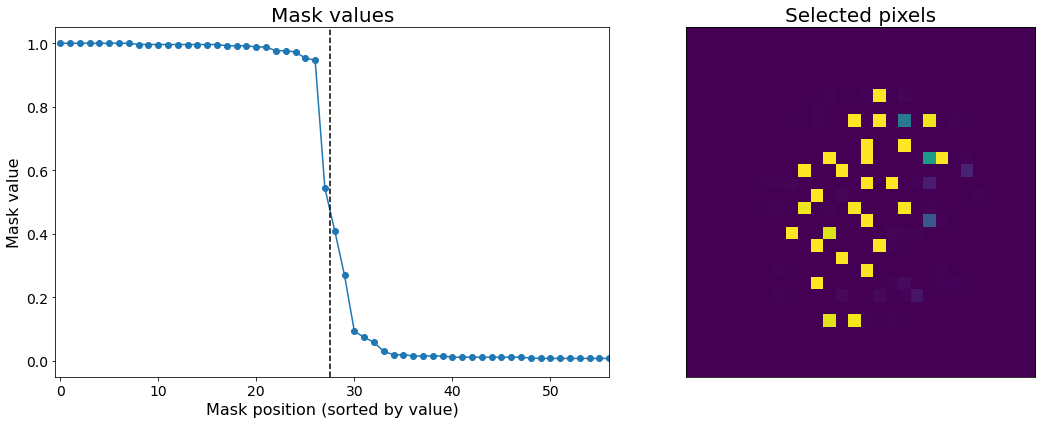

In [10]:
# Verify convergence
m = model.input_layer.sample(n_samples=256)
values = torch.mean(m, dim=0)
sorted_values = torch.sort(values, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
ax.plot(np.arange(input_size), sorted_values.cpu().data,
        marker='o')
ind = (sorted_values < 0.5).nonzero()[0].item()
ax.axvline(ind - 0.5, color='black', linestyle='--')
ax.set_xlim(-0.5, min(input_size, 2 * ind))
ax.set_title('Mask values', fontsize=20)
ax.set_xlabel('Mask position (sorted by value)', fontsize=16)
ax.set_ylabel('Mask value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(values.cpu().data, (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [11]:
# Extract selected inds
inds = model.get_inds(threshold=0.5)

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[512, 512],
    activation='elu').cuda()

model.learn(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(
    model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.936


# Concrete max

In [12]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_max',
    k=20,
    input_size=input_size,
    output_size=output_size,
    hidden=[512, 512],
    activation='elu').cuda()

# Train model
model.learn(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=300,
    start_temperature=10.0,
    end_temperature=0.01,
    loss_fn=nn.CrossEntropyLoss(),
    check_every=30)

--------Epoch = 30--------
Train loss = 0.1909
Val loss = 0.2271
Max = 0.01, Mean = 0.01, Min = 0.01
--------Epoch = 60--------
Train loss = 0.1347
Val loss = 0.1850
Max = 0.03, Mean = 0.03, Min = 0.02
--------Epoch = 90--------
Train loss = 0.2218
Val loss = 0.2505
Max = 0.14, Mean = 0.09, Min = 0.07
--------Epoch = 120--------
Train loss = 0.3114
Val loss = 0.3256
Max = 0.25, Mean = 0.18, Min = 0.15
--------Epoch = 150--------
Train loss = 0.3836
Val loss = 0.4023
Max = 0.43, Mean = 0.27, Min = 0.21
--------Epoch = 180--------
Train loss = 0.4570
Val loss = 0.4976
Max = 0.54, Mean = 0.37, Min = 0.29
--------Epoch = 210--------
Train loss = 0.4890
Val loss = 0.5192
Max = 0.52, Mean = 0.40, Min = 0.32
--------Epoch = 240--------
Train loss = 0.5251
Val loss = 0.5488
Max = 0.55, Mean = 0.42, Min = 0.35
--------Epoch = 270--------
Train loss = 0.5137
Val loss = 0.5473
Max = 0.57, Mean = 0.44, Min = 0.35
--------Epoch = 300--------
Train loss = 0.5147
Val loss = 0.5587
Max = 0.55, Mean = 

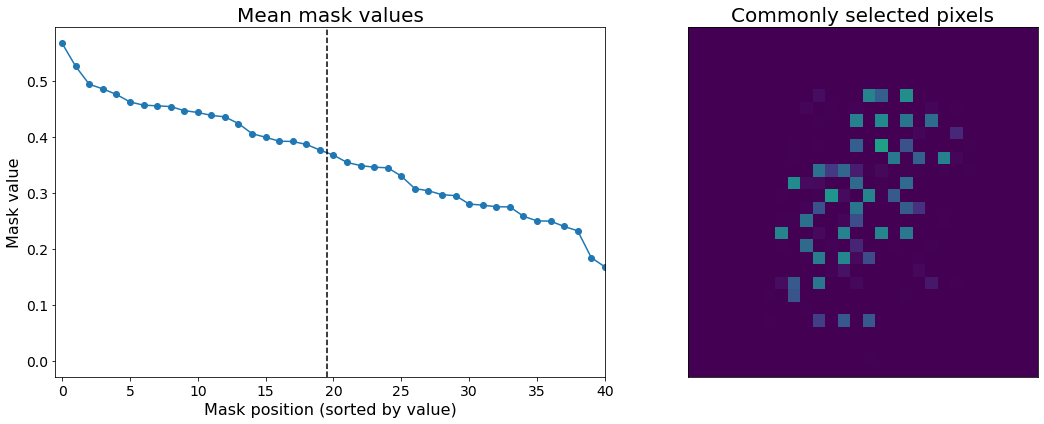

In [13]:
# Verify convergence
m = model.input_layer.sample(n_samples=256)
values = torch.mean(m, dim=0)
sorted_values = torch.sort(values, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
ax.plot(np.arange(input_size), sorted_values.cpu().data, marker='o')
ax.axvline(model.input_layer.k - 0.5, color='black', linestyle='--')
ax.set_xlim(-0.5, 2 * model.input_layer.k)
ax.set_title('Mean mask values', fontsize=20)
ax.set_xlabel('Mask position (sorted by value)', fontsize=16)
ax.set_ylabel('Mask value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(values.cpu().data, (28, 28)), vmin=0, vmax=1)
ax.set_title('Commonly selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [14]:
# Extract select inds
inds = model.get_inds()

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[512, 512],
    activation='elu').cuda()

model.learn(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(
    model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.906
